In [358]:
# import packages

import re
import time
from bs4 import BeautifulSoup as bs
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xlwt
from google.colab import drive
import nltk
nltk.download('stopwords')
from collections import defaultdict
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from nltk import sent_tokenize
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [359]:
# Connect Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [360]:
# Upload data from Google Drive

all_data_sentence = pd.read_csv('/content/drive/MyDrive/smartwatch/semi_final.csv', parse_dates= ['Date'])
all_data_sentence.reset_index(drop = False, inplace = True)
all_data_sentence2 = all_data_sentence[['old_index', 'Sentiment', 'topic_index','topic_value']]
all_data_sentence2

,old_index,Sentiment,topic_index,topic_value
0,0.0,1,6,0.076
1,0.0,1,11,0.056
2,0.0,1,8,0.047
3,1.0,1,5,0.029
4,1.0,1,4,0.094
...,...,...,...,...
144174,38208.0,1,7,0.075
144175,38208.0,1,6,0.265
144176,38208.0,1,9,0.067
144177,38209.0,1,10,0.023


Part 4. Transform Data set

In [361]:
a = all_data_sentence2.groupby(['old_index', 'topic_index'])['topic_value'].max().reset_index()
a

,old_index,topic_index,topic_value
0,0.0,6,0.076
1,0.0,8,0.047
2,0.0,11,0.056
3,1.0,3,0.019
4,1.0,4,0.094
...,...,...,...
96387,38208.0,6,0.265
96388,38208.0,7,0.075
96389,38208.0,9,0.067
96390,38209.0,10,0.023


In [362]:
b = a.merge(all_data_sentence, on = ['old_index', 'topic_index', 'topic_value'])
b

,old_index,topic_index,topic_value,index,Body,Date,Helpful,Link,Options,Product_Name,Rating,Region,Review,Sentiment,Title,Verified_Purchase,Sentiment Possibility
0,0.0,6,0.076,0,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,I received my Apple Watch next day,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.861715
1,0.0,8,0.047,2,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,You just need to buy a case protector for the ...,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.875764
2,0.0,11,0.056,1,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,New in a sealed box,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.683189
3,1.0,3,0.019,5,I prefer the feminine look of the smaller 38 t...,2018-12-30,104.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,The waterproof option is the reason I decided...,1,Upgrade from 42 gen 1..,Size: 38 mmColor: Silver Aluminum with White S...,0.823048
4,1.0,4,0.094,4,I prefer the feminine look of the smaller 38 t...,2018-12-30,104.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,I opted this go round for the cellular and so...,1,Upgrade from 42 gen 1..,Size: 38 mmColor: Silver Aluminum with White S...,0.994609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104109,38208.0,7,0.075,144173,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,Dont like the band,1,Dont like the band..,Color: PinkVerified Purchase,0.813162
104110,38208.0,7,0.075,144174,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,The band changes colors,1,Dont like the band..,Color: PinkVerified Purchase,0.829983
104111,38208.0,9,0.067,144176,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,The mobile app is fitness pro(used by fitbit),1,Dont like the band..,Color: PinkVerified Purchase,0.611888
104112,38209.0,10,0.023,144177,I like this product. It's basic which is what ...,2021-03-05,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Purple,Willful Smart Watch for Android Phones and iOS...,5.0,United States,Good value,1,Good value..,Color: PurpleVerified Purchase,0.946835


In [363]:
#b['y'] = b['topic_index'].astype(str) + '_' + b['Sentiment'].astype(str)
b['y'] = b['topic_index'].astype(str)
b

,old_index,topic_index,topic_value,index,Body,Date,Helpful,Link,Options,Product_Name,Rating,Region,Review,Sentiment,Title,Verified_Purchase,Sentiment Possibility,y
0,0.0,6,0.076,0,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,I received my Apple Watch next day,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.861715,6
1,0.0,8,0.047,2,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,You just need to buy a case protector for the ...,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.875764,8
2,0.0,11,0.056,1,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,New in a sealed box,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.683189,11
3,1.0,3,0.019,5,I prefer the feminine look of the smaller 38 t...,2018-12-30,104.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,The waterproof option is the reason I decided...,1,Upgrade from 42 gen 1..,Size: 38 mmColor: Silver Aluminum with White S...,0.823048,3
4,1.0,4,0.094,4,I prefer the feminine look of the smaller 38 t...,2018-12-30,104.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,I opted this go round for the cellular and so...,1,Upgrade from 42 gen 1..,Size: 38 mmColor: Silver Aluminum with White S...,0.994609,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104109,38208.0,7,0.075,144173,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,Dont like the band,1,Dont like the band..,Color: PinkVerified Purchase,0.813162,7
104110,38208.0,7,0.075,144174,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,The band changes colors,1,Dont like the band..,Color: PinkVerified Purchase,0.829983,7
104111,38208.0,9,0.067,144176,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,The mobile app is fitness pro(used by fitbit),1,Dont like the band..,Color: PinkVerified Purchase,0.611888,9
104112,38209.0,10,0.023,144177,I like this product. It's basic which is what ...,2021-03-05,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Purple,Willful Smart Watch for Android Phones and iOS...,5.0,United States,Good value,1,Good value..,Color: PurpleVerified Purchase,0.946835,10


In [364]:
c = pd.get_dummies(b, columns = ['y'])
c

,old_index,topic_index,topic_value,index,Body,Date,Helpful,Link,Options,Product_Name,Rating,Region,Review,Sentiment,Title,Verified_Purchase,Sentiment Possibility,y_0,y_1,y_10,y_11,y_12,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9
0,0.0,6,0.076,0,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,I received my Apple Watch next day,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.861715,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.0,8,0.047,2,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,You just need to buy a case protector for the ...,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.875764,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,11,0.056,1,I received my Apple Watch next day! Free shipp...,2019-04-11,131.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,New in a sealed box,1,Love love love it..,Size: 38 mmColor: Silver Aluminum with White S...,0.683189,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,3,0.019,5,I prefer the feminine look of the smaller 38 t...,2018-12-30,104.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,The waterproof option is the reason I decided...,1,Upgrade from 42 gen 1..,Size: 38 mmColor: Silver Aluminum with White S...,0.823048,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,4,0.094,4,I prefer the feminine look of the smaller 38 t...,2018-12-30,104.0,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",5.0,United States,I opted this go round for the cellular and so...,1,Upgrade from 42 gen 1..,Size: 38 mmColor: Silver Aluminum with White S...,0.994609,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104109,38208.0,7,0.075,144173,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,Dont like the band,1,Dont like the band..,Color: PinkVerified Purchase,0.813162,0,0,0,0,0,0,0,0,0,0,1,0,0
104110,38208.0,7,0.075,144174,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,The band changes colors,1,Dont like the band..,Color: PinkVerified Purchase,0.829983,0,0,0,0,0,0,0,0,0,0,1,0,0
104111,38208.0,9,0.067,144176,The band changes colors. Now it looks dirty. I...,2021-02-28,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,Willful Smart Watch for Android Phones and iOS...,3.0,United States,The mobile app is fitness pro(used by fitbit),1,Dont like the band..,Color: PinkVerified Purchase,0.611888,0,0,0,0,0,0,0,0,0,0,0,0,1
104112,38209.0,10,0.023,144177,I like this product. It's basic which is what ...,2021-03-05,NaN,https://www.amazon.com/Willful-Compatible-Swim...,Color: Purple,Willful Smart Watch for Android Phones and iOS...,5.0,United States,Good value,1,Good value..,Color: PurpleVerified Purchase,0.946835,0,0,1,0,0,0,0,0,0,0,0,0,0


In [365]:
c['y_0'].value_counts()

0    99742
1     4372
Name: y_0, dtype: int64

In [366]:
c = c.astype({'y_0': 'int', 'y_1': 'int', 'y_2': 'int', 'y_3': 'int', 'y_4': 'int','y_5': 'int', 'y_6': 'int',
              'y_7': 'int', 'y_8': 'int', 'y_9': 'int', 'y_10': 'int', 'y_11': 'int', 'y_12': 'int'})

In [367]:
for i in range(len(b)):
  if b['Sentiment'][i] == 0:
    topic_num = b['y'][i]
    c['y_{}'.format(topic_num)][i] = -1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [368]:
y_col = c.columns[c.columns.str.startswith('y_')]
y_col

Index(['y_0', 'y_1', 'y_10', 'y_11', 'y_12', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6',
       'y_7', 'y_8', 'y_9'],
      dtype='object')

In [369]:
c['y_0'].value_counts()

 0    99742
 1     2697
-1     1675
Name: y_0, dtype: int64

In [370]:
c.groupby('old_index')['Rating'].max()

old_index
0.0        5.0
1.0        5.0
2.0        4.0
3.0        5.0
4.0        5.0
          ... 
38205.0    4.0
38206.0    5.0
38207.0    5.0
38208.0    3.0
38209.0    5.0
Name: Rating, Length: 33924, dtype: float64

In [371]:
all_data = c.groupby('old_index')[y_col].agg(['min', 'max'])
all_data.reset_index(drop = False, inplace = True)
old_index = all_data['old_index']
all_data.drop(['old_index'], axis = 1, inplace =True)
all_data

dropping on a non-lexsorted multi-index without a level parameter may impact performance.


y_0     y_1     y_10     y_11      ... y_6     y_7     y_8     y_9    
      min max min max  min max  min max  ... min max min max min max min max
0       0   0   0   0    0   0    0   1  ...   0   1   0   0   0   1   0   0
1       0   0   0   0    0   0    0   0  ...   0   0   0   0   0   1   0   0
2       0   0   0   1   -1   0    0   1  ...   0   0   0   0   0   0   0   0
3       0   0   0   0    0   0    0   1  ...   0   0   0   1  -1   0   0   0
4       0   0   0   0    0   0    0   0  ...   0   0   0   0   0   1   0   1
...    ..  ..  ..  ..  ...  ..  ...  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..
33919   0   0   0   1    0   0    0   0  ...   0   0   0   0   0   0   0   0
33920   0   0   0   0    0   0    0   0  ...   1   1   0   0   0   0   0   0
33921   0   0   0   0    0   0    0   0  ...   0   1   0   1   0   1   0   0
33922   0   0   0   0    0   0    0   0  ...   0   1   0   1   0   0   0   1
33923   0   0   0   0    0   1    0   1  ...   0   0   0   0   0   0   0   0

[33924 rows x 26 columns]

In [372]:
agg_data = pd.DataFrame()
agg_data['y_0'] = all_data['y_0']['min'] + all_data['y_0']['max']
agg_data['y_1'] = all_data['y_1']['min'] + all_data['y_1']['max']
agg_data['y_2'] = all_data['y_2']['min'] + all_data['y_2']['max']
agg_data['y_3'] = all_data['y_3']['min'] + all_data['y_3']['max']
agg_data['y_4'] = all_data['y_4']['min'] + all_data['y_4']['max']
agg_data['y_5'] = all_data['y_5']['min'] + all_data['y_5']['max']
agg_data['y_6'] = all_data['y_6']['min'] + all_data['y_6']['max']
agg_data['y_7'] = all_data['y_7']['min'] + all_data['y_7']['max']
agg_data['y_8'] = all_data['y_8']['min'] + all_data['y_8']['max']
agg_data['y_9'] = all_data['y_9']['min'] + all_data['y_9']['max']
agg_data['y_10'] = all_data['y_10']['min'] + all_data['y_9']['max']
agg_data['y_11'] = all_data['y_11']['min'] + all_data['y_9']['max']
agg_data['y_12'] = all_data['y_12']['min'] + all_data['y_9']['max']
all_data = agg_data
all_data

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12
0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,-1,0,0
3,0,0,1,0,0,-1,0,1,-1,0,0,0,0
4,0,0,0,0,1,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33919,0,1,0,0,1,0,0,0,0,0,0,0,0
33920,0,0,0,0,0,0,2,0,0,0,0,0,0
33921,0,0,0,0,0,0,1,1,1,0,0,0,0
33922,0,0,0,0,0,0,1,1,0,1,1,1,1


In [373]:
all_data.replace(-2, -1, inplace = True)
all_data.replace(-3, -1, inplace = True)
all_data.replace(-4, -1, inplace = True)
all_data.replace(-5, -1, inplace = True)
all_data.replace(2, 1, inplace = True)
all_data.replace(3, 1, inplace = True)
all_data.replace(4, 1, inplace = True)
all_data.replace(5, 1, inplace = True)
all_data

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12
0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,-1,0,0
3,0,0,1,0,0,-1,0,1,-1,0,0,0,0
4,0,0,0,0,1,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33919,0,1,0,0,1,0,0,0,0,0,0,0,0
33920,0,0,0,0,0,0,1,0,0,0,0,0,0
33921,0,0,0,0,0,0,1,1,1,0,0,0,0
33922,0,0,0,0,0,0,1,1,0,1,1,1,1


In [374]:
all_data['old_index'] = old_index
all_data

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,old_index
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0
1,0,0,0,1,1,1,0,0,1,0,0,0,0,1.0
2,0,1,0,0,0,0,0,0,0,0,-1,0,0,2.0
3,0,0,1,0,0,-1,0,1,-1,0,0,0,0,3.0
4,0,0,0,0,1,0,0,0,1,1,1,1,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33919,0,1,0,0,1,0,0,0,0,0,0,0,0,38205.0
33920,0,0,0,0,0,0,1,0,0,0,0,0,0,38206.0
33921,0,0,0,0,0,0,1,1,1,0,0,0,0,38207.0
33922,0,0,0,0,0,0,1,1,0,1,1,1,1,38208.0


In [375]:
b[b['old_index'] == 33211]

,old_index,topic_index,topic_value,index,Body,Date,Helpful,Link,Options,Product_Name,Rating,Region,Review,Sentiment,Title,Verified_Purchase,Sentiment Possibility,y
87771,33211.0,8,0.029,122483,Loving this. This watch does everything I need...,2018-01-06,NaN,https://www.amazon.com/Samsung-Sport-Smartwatc...,Color: BlueStyle: Watch Only,"Samsung Gear Sport Smartwatch (Bluetooth), Bla...",5.0,United States,This watch does everything I needed it to,1,Five Stars..,Color: BlueStyle: Watch OnlyVerified Purchase,0.906616,8


In [376]:
#all_data = c.groupby('old_index')[y_col].sum()
#all_data.reset_index(drop = False, inplace = True)
all_data['Rating'] = c.groupby('old_index')['Rating']
for i in range((len(all_data))):
  all_data['Rating'][i] = all_data['Rating'][i][1].iloc[0]
all_data['Helpful'] = c.groupby('old_index')['Helpful'].max()
all_data['Product_Name'] = c.groupby('old_index')['Product_Name'].max()
all_data['Date'] = c.groupby('old_index')['Date'].max()
all_data['Link'] = c.groupby('old_index')['Link'].max()
all_data['Options'] = c.groupby('old_index')['Options'].max()
all_data['Region'] = c.groupby('old_index')['Region'].max()
all_data['Verified_Purchase'] = c.groupby('old_index')['Verified_Purchase'].max()
all_data


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,old_index,Rating,Helpful,Product_Name,Date,Link,Options,Region,Verified_Purchase
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,5,131.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-04-11,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Size: 38 mmColor: Silver Aluminum with White S...
1,0,0,0,1,1,1,0,0,1,0,0,0,0,1.0,5,104.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-30,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Size: 38 mmColor: Silver Aluminum with White S...
2,0,1,0,0,0,0,0,0,0,0,-1,0,0,2.0,4,84.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-06,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Size: 42 mmColor: Space Gray Aluminum with Bla...
3,0,0,1,0,0,-1,0,1,-1,0,0,0,0,3.0,5,81.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-10,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Size: 42 mmColor: Space Gray Aluminum with Bla...
4,0,0,0,0,1,0,0,0,1,1,1,1,1,4.0,5,3.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-11-12,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Size: 38 mmColor: Silver Aluminum with White S...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33919,0,1,0,0,1,0,0,0,0,0,0,0,0,38205.0,4,NaN,Willful Smart Watch for Android Phones and iOS...,2020-06-19,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Color: PinkVerified Purchase
33920,0,0,0,0,0,0,1,0,0,0,0,0,0,38206.0,5,NaN,Willful Smart Watch for Android Phones and iOS...,2021-02-01,https://www.amazon.com/Willful-Compatible-Swim...,Color: Dark Purple,United States,Color: Dark PurpleVerified Purchase
33921,0,0,0,0,0,0,1,1,1,0,0,0,0,38207.0,5,1.0,Willful Smart Watch for Android Phones and iOS...,2020-12-25,https://www.amazon.com/Willful-Compatible-Swim...,Color: Green-Gold,United States,Color: Green-GoldVerified Purchase
33922,0,0,0,0,0,0,1,1,0,1,1,1,1,38208.0,3,NaN,Willful Smart Watch for Android Phones and iOS...,2021-01-10,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Color: PinkVerified Purchase


In [377]:
for i in range((len(all_data))):
  try:
    all_data['Verified_Purchase'][i] = all_data['Verified_Purchase'][i][-17:]
  except:
    pass

for i in range((len(all_data))):
  if all_data['Verified_Purchase'][i] != 'Verified Purchase':
    all_data['Verified_Purchase'][i] = 'Unverified Purchase'

all_data


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,old_index,Rating,Helpful,Product_Name,Date,Link,Options,Region,Verified_Purchase
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,5,131.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-04-11,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
1,0,0,0,1,1,1,0,0,1,0,0,0,0,1.0,5,104.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-30,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
2,0,1,0,0,0,0,0,0,0,0,-1,0,0,2.0,4,84.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-06,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Verified Purchase
3,0,0,1,0,0,-1,0,1,-1,0,0,0,0,3.0,5,81.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-10,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Verified Purchase
4,0,0,0,0,1,0,0,0,1,1,1,1,1,4.0,5,3.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-11-12,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33919,0,1,0,0,1,0,0,0,0,0,0,0,0,38205.0,4,NaN,Willful Smart Watch for Android Phones and iOS...,2020-06-19,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Verified Purchase
33920,0,0,0,0,0,0,1,0,0,0,0,0,0,38206.0,5,NaN,Willful Smart Watch for Android Phones and iOS...,2021-02-01,https://www.amazon.com/Willful-Compatible-Swim...,Color: Dark Purple,United States,Verified Purchase
33921,0,0,0,0,0,0,1,1,1,0,0,0,0,38207.0,5,1.0,Willful Smart Watch for Android Phones and iOS...,2020-12-25,https://www.amazon.com/Willful-Compatible-Swim...,Color: Green-Gold,United States,Verified Purchase
33922,0,0,0,0,0,0,1,1,0,1,1,1,1,38208.0,3,NaN,Willful Smart Watch for Android Phones and iOS...,2021-01-10,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Verified Purchase


In [378]:
all_data['Helpful'] = all_data['Helpful'].fillna(0)
all_data

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,old_index,Rating,Helpful,Product_Name,Date,Link,Options,Region,Verified_Purchase
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,5,131.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-04-11,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
1,0,0,0,1,1,1,0,0,1,0,0,0,0,1.0,5,104.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-30,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
2,0,1,0,0,0,0,0,0,0,0,-1,0,0,2.0,4,84.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-06,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Verified Purchase
3,0,0,1,0,0,-1,0,1,-1,0,0,0,0,3.0,5,81.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-10,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Verified Purchase
4,0,0,0,0,1,0,0,0,1,1,1,1,1,4.0,5,3.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-11-12,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33919,0,1,0,0,1,0,0,0,0,0,0,0,0,38205.0,4,0.0,Willful Smart Watch for Android Phones and iOS...,2020-06-19,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Verified Purchase
33920,0,0,0,0,0,0,1,0,0,0,0,0,0,38206.0,5,0.0,Willful Smart Watch for Android Phones and iOS...,2021-02-01,https://www.amazon.com/Willful-Compatible-Swim...,Color: Dark Purple,United States,Verified Purchase
33921,0,0,0,0,0,0,1,1,1,0,0,0,0,38207.0,5,1.0,Willful Smart Watch for Android Phones and iOS...,2020-12-25,https://www.amazon.com/Willful-Compatible-Swim...,Color: Green-Gold,United States,Verified Purchase
33922,0,0,0,0,0,0,1,1,0,1,1,1,1,38208.0,3,0.0,Willful Smart Watch for Android Phones and iOS...,2021-01-10,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Verified Purchase


In [379]:
e = all_data.groupby(['Product_Name'])['Options'].value_counts()
e

Product_Name                                                                                                                                                                                           Options                                                    
Apple Watch Series 3 (GPS + Cellular, 38mm) - Silver Aluminum Case with White Sport Band                                                                                                               Size: 38 mmColor: Silver Aluminum with White Sport Band         289
                                                                                                                                                                                                       Size: 38 mmColor: Space Gray Aluminum with Black Sport Band     180
                                                                                                                                                                                                       Size: 42

In [380]:
all_data.columns.str.startswith('y_')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False])

In [381]:
all_data = all_data[all_data['Rating'].notnull()]
all_data

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,old_index,Rating,Helpful,Product_Name,Date,Link,Options,Region,Verified_Purchase
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,5,131.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-04-11,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
1,0,0,0,1,1,1,0,0,1,0,0,0,0,1.0,5,104.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-30,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
2,0,1,0,0,0,0,0,0,0,0,-1,0,0,2.0,4,84.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-06,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Verified Purchase
3,0,0,1,0,0,-1,0,1,-1,0,0,0,0,3.0,5,81.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2018-12-10,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 42 mmColor: Space Gray Aluminum with Bla...,United States,Verified Purchase
4,0,0,0,0,1,0,0,0,1,1,1,1,1,4.0,5,3.0,"Apple Watch Series 3 (GPS + Cellular, 38mm) - ...",2019-11-12,https://www.amazon.com/Apple-Watch-GPS-Cellula...,Size: 38 mmColor: Silver Aluminum with White S...,United States,Verified Purchase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33919,0,1,0,0,1,0,0,0,0,0,0,0,0,38205.0,4,0.0,Willful Smart Watch for Android Phones and iOS...,2020-06-19,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Verified Purchase
33920,0,0,0,0,0,0,1,0,0,0,0,0,0,38206.0,5,0.0,Willful Smart Watch for Android Phones and iOS...,2021-02-01,https://www.amazon.com/Willful-Compatible-Swim...,Color: Dark Purple,United States,Verified Purchase
33921,0,0,0,0,0,0,1,1,1,0,0,0,0,38207.0,5,1.0,Willful Smart Watch for Android Phones and iOS...,2020-12-25,https://www.amazon.com/Willful-Compatible-Swim...,Color: Green-Gold,United States,Verified Purchase
33922,0,0,0,0,0,0,1,1,0,1,1,1,1,38208.0,3,0.0,Willful Smart Watch for Android Phones and iOS...,2021-01-10,https://www.amazon.com/Willful-Compatible-Swim...,Color: Pink,United States,Verified Purchase


In [382]:
a = all_data[all_data['Product_Name'] == 'Samsung Gear S3 Frontier Smartwatch (Bluetooth), SM-R760NDAAXAR']
b = all_data[all_data['Product_Name'] == 'Samsung Galaxy Watch (46mm, GPS, Bluetooth, Unlocked LTE) – Silver/Black (US Version)']
c = all_data[all_data['Product_Name'] == 'Samsung Galaxy Watch (42mm, GPS, Bluetooth, Unlocked LTE) – Midnight Black (US Version)']
d = all_data[all_data['Product_Name'] == 'SAMSUNG Galaxy Watch Active 2 (40mm, GPS, Bluetooth) Smart Watch with Advanced Health Monitoring, Fitness Tracking, and Long lasting Battery, Silver (US Version)']
e = all_data[all_data['Product_Name'] == 'Samsung Gear Sport Smartwatch (Bluetooth), Black, SM-R600NZKAXAR – US Version with Warranty']
f = all_data[all_data['Product_Name'] == 'SAMSUNG Galaxy Watch 3 (45mm, GPS, Bluetooth) Smart Watch with Advanced Health Monitoring, Fitness Tracking, and Long lasting Battery - Mystic Silver (US Version)']
g = all_data[all_data['Product_Name'] == 'Samsung Galaxy Fit Black (Bluetooth), SM-R370NZKAXAR – US Version with Warranty']
h = all_data[all_data['Product_Name'] == 'SAMSUNG Galaxy Fit 2 Bluetooth Fitness Tracking Smart Band – Black (US Version)']

all_data = pd.concat([a, b, c, d, e, f, g, h])
all_data

In [383]:
# all_data = pd.concat([a, b, c, d])
# all_data

In [385]:
y = all_data['Rating']
all_data2 = all_data[all_data.columns[all_data.columns.str.startswith('y_')]]
all_data2

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12
432,0,0,-1,-1,1,0,1,0,-1,0,0,0,0
433,0,0,0,1,1,1,1,0,0,0,0,0,0
434,0,1,0,0,0,1,1,1,1,0,0,0,0
435,0,1,1,1,-1,0,1,1,1,1,1,1,1
436,0,0,1,0,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,0,0,0,0,0,0,0,0,0,0,0,1,0
16684,0,0,0,0,0,0,0,0,0,0,0,1,0
16685,0,0,0,0,0,0,0,0,1,0,0,0,0
16686,0,0,0,0,0,0,0,0,0,0,0,1,0


In [386]:
all_data2.describe()

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12
count,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000,14852.000000
mean,0.029558,0.147320,0.063560,0.108066,0.172165,0.069149,0.206706,0.094937,0.373283,0.125370,0.121398,0.099448,0.125303
std,0.349304,0.423031,0.404673,0.397077,0.489522,0.394049,0.589302,0.353721,0.593918,0.387551,0.430796,0.473677,0.390084
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [387]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# all_data3 = pd.DataFrame(ss.fit_transform(all_data2), columns = all_data2.columns)
# all_data3

In [388]:
all_data2 = all_data2.rename(columns = {'y_0': 'band', 'y_1': 'connection', 'y_2': 'appearance', 'y_3': 'price', 'y_4': 'time', 'y_5': 'display', 'y_6': 'sport', 'y_7':'warranty&issue', 'y_8': 'ecommerce platform', 'y_9': 'app&software', 'y_10': 'waterproof&damage', 'y_11': 'battery', 'y_12': 'track&sleep'})

In [389]:
all_data2

,band,connection,appearance,price,time,display,sport,warranty&issue,ecommerce platform,app&software,waterproof&damage,battery,track&sleep
432,0,0,-1,-1,1,0,1,0,-1,0,0,0,0
433,0,0,0,1,1,1,1,0,0,0,0,0,0
434,0,1,0,0,0,1,1,1,1,0,0,0,0
435,0,1,1,1,-1,0,1,1,1,1,1,1,1
436,0,0,1,0,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,0,0,0,0,0,0,0,0,0,0,0,1,0
16684,0,0,0,0,0,0,0,0,0,0,0,1,0
16685,0,0,0,0,0,0,0,0,1,0,0,0,0
16686,0,0,0,0,0,0,0,0,0,0,0,1,0


In [390]:
y.sort_values()

16687    1
17678    1
17684    1
17697    1
17711    1
        ..
25537    5
29855    5
19115    5
25539    5
432      5
Name: Rating, Length: 14852, dtype: object

In [391]:
all_data['y_11'].value_counts()

 0    11373
 1     2478
-1     1001
Name: y_11, dtype: int64

In [392]:
all_data2 = all_data2.replace({0:np.nan})
all_data2

,band,connection,appearance,price,time,display,sport,warranty&issue,ecommerce platform,app&software,waterproof&damage,battery,track&sleep
432,NaN,NaN,-1.0,-1.0,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN
433,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
434,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
435,NaN,1.0,1.0,1.0,-1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
436,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
16684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
16685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
16686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [393]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state = 42) # n_splits는 높을수록 좋다
xgb = XGBRegressor(n_estimators=10000, learning_rate=0.05, max_depth = 8, colsample_bytree = 0.4, subsample = 0.8)
result = 0
best_score = 0
#n_estimators 기본값 100, early_stopping_rounds로 두면 어차피 멈추니깐 n_estimator 높게 설정
for train_index, valid_index in kf.split(all_data2):
    x_train, x_valid = all_data2.iloc[train_index], all_data2.iloc[valid_index]
    y_train, y_valid = all_data['Rating'].iloc[train_index], all_data['Rating'].iloc[valid_index]
    xgb.fit(x_train, y_train, eval_set = [(x_valid, y_valid)], verbose = 25, eval_metric = 'rmse', early_stopping_rounds = 50)    
    best_score += np.min(xgb.evals_result_['validation_0']['rmse'])/10
    # 5번 교차검증할건데 각각의 시행에서 0.2의 가중치 부여
    #result += xgb.predict(test2)/5

[03:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.6284
Will train until validation_0-rmse hasn't improved in 50 rounds.
[25]	validation_0-rmse:1.56147
[50]	validation_0-rmse:1.22382
[75]	validation_0-rmse:1.18618
[100]	validation_0-rmse:1.17935
[125]	validation_0-rmse:1.17927
[150]	validation_0-rmse:1.17952
[175]	validation_0-rmse:1.1792
[200]	validation_0-rmse:1.17949
[225]	validation_0-rmse:1.18051
Stopping. Best iteration:
[183]	validation_0-rmse:1.17869

[03:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.58102
Will train until validation_0-rmse hasn't improved in 50 rounds.
[25]	validation_0-rmse:1.56368
[50]	validation_0-rmse:1.25642
[75]	validation_0-rmse:1.22127
[100]	validation_0-rmse:1.21096
[125]	validation_0-rmse:1.20729
[150]	validation_0-rmse:1.20443
[175]	validation_0-rmse:1

In [394]:
best_score

1.1685402

In [395]:
!pip install shap
import shap
import keras


In [396]:
pro_index = all_data[all_data['Product_Name'] == 'Letsfit Smart Watch, Fitness Tracker with Heart Rate Monitor, Activity Tracker with 1.3 Inch Touch Screen, IP68 Waterproof Pedometer Smartwatch with Sleep Monitor, Step Counter for Women and Men'].index

In [397]:
all_data2

,band,connection,appearance,price,time,display,sport,warranty&issue,ecommerce platform,app&software,waterproof&damage,battery,track&sleep
432,NaN,NaN,-1.0,-1.0,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN
433,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
434,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
435,NaN,1.0,1.0,1.0,-1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
436,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
16684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
16685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
16686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [398]:
explainer = shap.TreeExplainer(xgb)
sample = all_data2.sample(3000)
#sample = all_data2.iloc[pro_index]
shap_values = explainer.shap_values(sample)
shap_values

array([[ 1.01411127e-01,  2.12078691e-02,  3.85567471e-02, ...,
        -1.73217370e-04,  6.11454956e-02,  1.86964441e-02],
       [ 8.64507630e-02,  2.32522730e-02,  3.59880142e-02, ...,
        -4.80009243e-03,  5.04720993e-02,  1.68233644e-02],
       [ 1.09146498e-01,  4.40669879e-02,  5.67360222e-02, ...,
         2.17180625e-01,  6.71266392e-02,  3.31199653e-02],
       ...,
       [ 8.99519548e-02,  2.35028137e-02,  4.74041104e-02, ...,
         1.34834483e-01,  1.18204646e-01, -5.58413006e-02],
       [ 9.18042883e-02,  5.14925048e-02, -1.43559024e-01, ...,
        -1.02189869e-01, -5.84051423e-02, -5.19963838e-02],
       [ 9.10729468e-02,  1.11741005e-02,  4.03375886e-02, ...,
         2.74935993e-03,  4.75426689e-02,  1.96194090e-02]], dtype=float32)

In [399]:
shap_values

array([[ 1.01411127e-01,  2.12078691e-02,  3.85567471e-02, ...,
        -1.73217370e-04,  6.11454956e-02,  1.86964441e-02],
       [ 8.64507630e-02,  2.32522730e-02,  3.59880142e-02, ...,
        -4.80009243e-03,  5.04720993e-02,  1.68233644e-02],
       [ 1.09146498e-01,  4.40669879e-02,  5.67360222e-02, ...,
         2.17180625e-01,  6.71266392e-02,  3.31199653e-02],
       ...,
       [ 8.99519548e-02,  2.35028137e-02,  4.74041104e-02, ...,
         1.34834483e-01,  1.18204646e-01, -5.58413006e-02],
       [ 9.18042883e-02,  5.14925048e-02, -1.43559024e-01, ...,
        -1.02189869e-01, -5.84051423e-02, -5.19963838e-02],
       [ 9.10729468e-02,  1.11741005e-02,  4.03375886e-02, ...,
         2.74935993e-03,  4.75426689e-02,  1.96194090e-02]], dtype=float32)

In [400]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], sample.iloc[7,:])

In [401]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, sample)

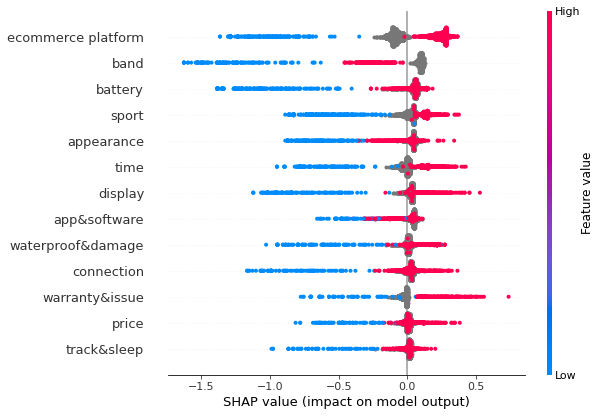

In [402]:
# 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
#  이는 각 변수의 shap value에 절대값을 취한 것으로 변수의 평균적인 영향력을 보여준다. 큰 영향력을 보일 수록, target과 관계성(인과관계X)이 크다는 것이다. 즉, 변수의 중요도와 비슷한 개념이다. 
shap.summary_plot(shap_values, sample, plot_type = "dot")

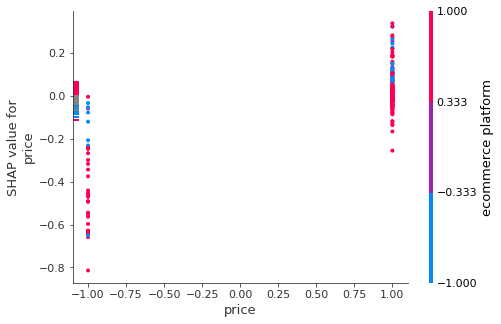

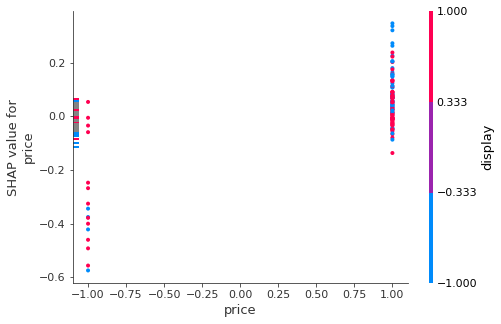

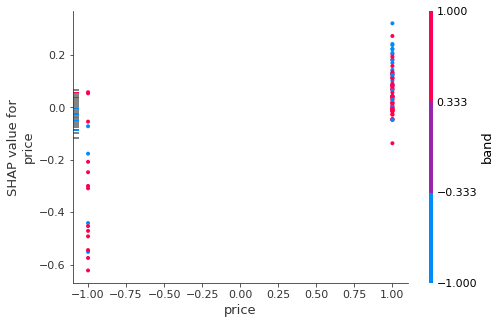

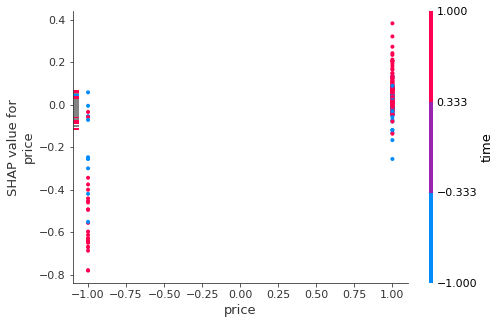

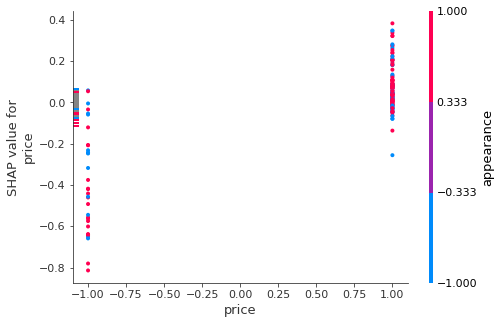

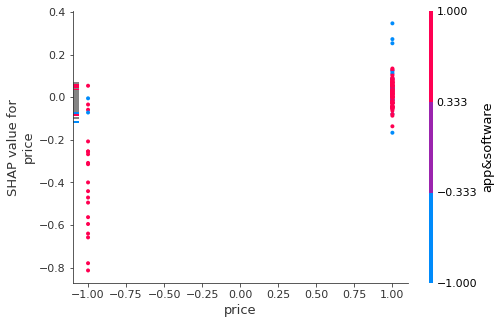

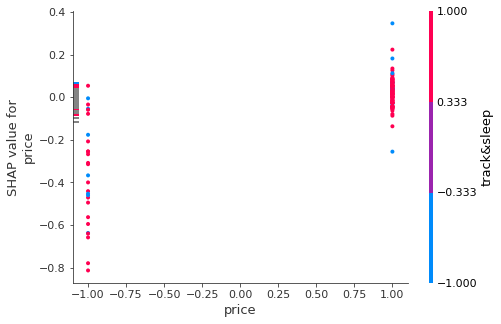

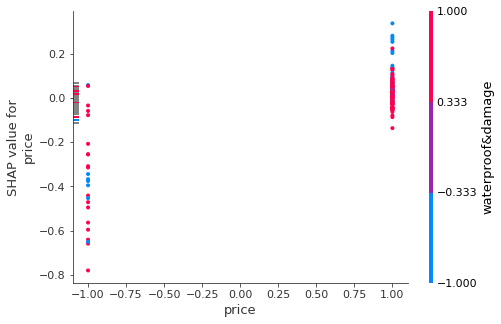

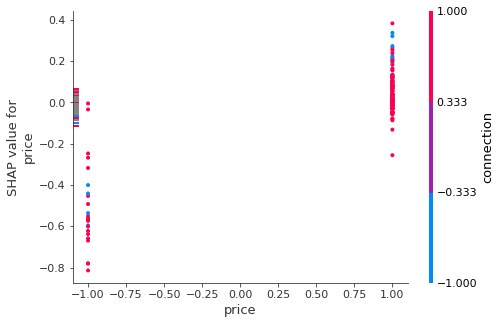

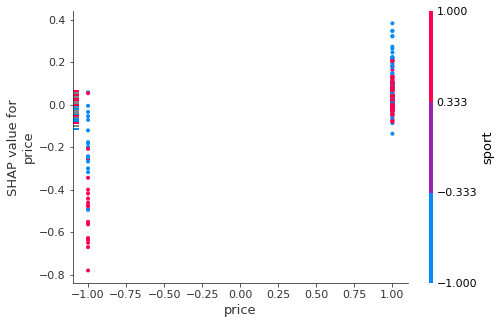

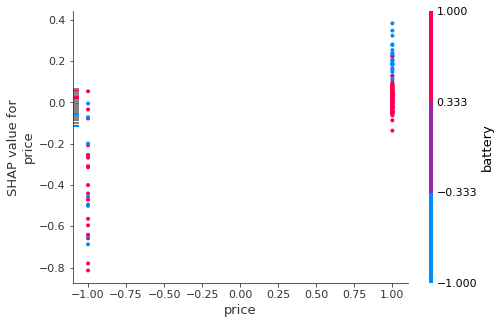

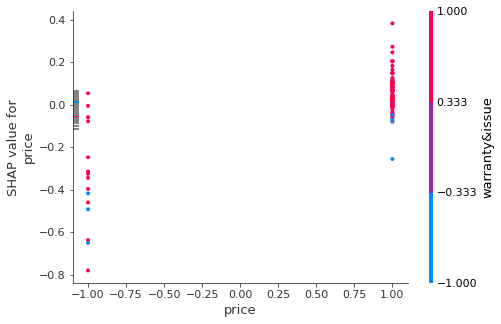

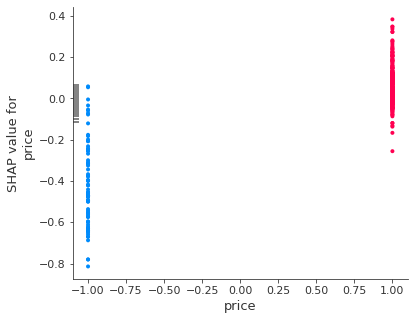

<function shap.plots._scatter.dependence_legacy>

In [410]:
# 변수 간의 shap value 파악
inds = shap.approximate_interactions("price", shap_values, sample)
for i in range(13):
  shap.dependence_plot("price", shap_values, sample, interaction_index=inds[i])
shap.dependence_plot

In [404]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

In [405]:
pi = PermutationImportance(xgb, random_state = 42).fit(all_data2, y)
pi

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=0.4, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.05,
                                             max_delta_step=0, max_depth=8,
                                             min_child_weight=1, missing=None,
                                             n_estimators=10000, n_jobs=1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                  

In [406]:
eli5.show_weights(pi,feature_names = np.array(all_data2.columns))

Weight,Feature
0.1192 ± 0.0041,ecommerce platform
0.1141 ± 0.0049,band
0.1126 ± 0.0028,battery
0.0686 ± 0.0030,sport
0.0570 ± 0.0053,display
0.0516 ± 0.0027,waterproof&damage
0.0511 ± 0.0033,app&software
0.0489 ± 0.0023,time
0.0442 ± 0.0031,connection
0.0422 ± 0.0032,appearance


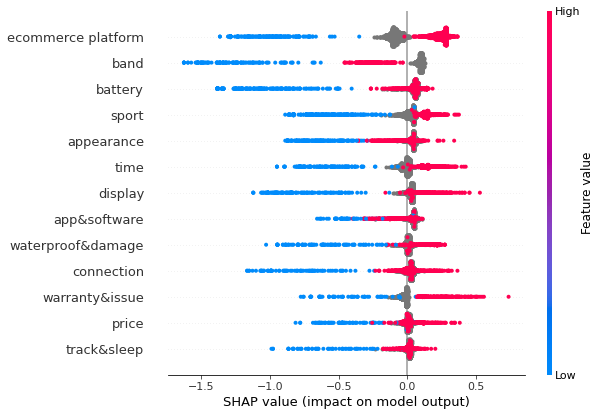

In [407]:
shap.summary_plot(shap_values, sample, plot_type="dot", max_display=all_data2.shape[1])

In [408]:
all_data['Product_Name'].value_counts()


Samsung Gear S3 Frontier Smartwatch (Bluetooth), SM-R760NDAAXAR                                                                                                       3496
Samsung Galaxy Watch (46mm, GPS, Bluetooth, Unlocked LTE) – Silver/Black (US Version)                                                                                 3310
Samsung Galaxy Watch (42mm, GPS, Bluetooth, Unlocked LTE) – Midnight Black (US Version)                                                                               3301
SAMSUNG Galaxy Watch Active 2 (40mm, GPS, Bluetooth) Smart Watch with Advanced Health Monitoring, Fitness Tracking, and Long lasting Battery, Silver (US Version)     2689
Samsung Gear Sport Smartwatch (Bluetooth), Black, SM-R600NZKAXAR – US Version with Warranty                                                                            803
SAMSUNG Galaxy Watch 3 (45mm, GPS, Bluetooth) Smart Watch with Advanced Health Monitoring, Fitness Tracking, and Long lasting Battery - Mystic Si

In [409]:
pro_index = all_data[all_data['Product_Name'] == 'Samsung Gear S3 Frontier Smartwatch (Bluetooth), SM-R760NDAAXAR'].index
explainer = shap.TreeExplainer(xgb)
sample = all_data2.iloc[pro_index]
shap_values = explainer.shap_values(sample)

IndexError: ignored

In [ ]:
shap.summary_plot(shap_values, sample, plot_type="dot", max_display=all_data2.shape[1])

In [ ]:
pro_index = all_data[all_data['Product_Name'] == 'New Apple Watch Series 6 (GPS, 40mm) - Blue Aluminum Case with Deep Navy Sport Band'].index
explainer = shap.TreeExplainer(xgb)
sample = all_data2.iloc[pro_index]
shap_values = explainer.shap_values(sample)

In [ ]:
shap.summary_plot(shap_values, sample, plot_type="dot", max_display=all_data2.shape[1])

In [ ]:
product_list[0]

In [ ]:
pro_index = all_data[all_data['Product_Name'] == 'Letsfit Smart Watch, Fitness Tracker with Heart Rate Monitor, Activity Tracker with 1.3 Inch Touch Screen, IP68 Waterproof Pedometer Smartwatch with Sleep Monitor, Step Counter for Women and Men'].index
explainer = shap.TreeExplainer(xgb)
sample = all_data2.iloc[pro_index]
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, plot_type="dot", max_display=all_data2.shape[1])

In [ ]:
pro_index = all_data[all_data['Product_Name'] == 'Fitbit Versa 3 Health & Fitness Smartwatch with GPS, 24/7 Heart Rate, Alexa Built-in, 6+ Days Battery, Black/Black, One Size (S & L Bands Included)'].index
explainer = shap.TreeExplainer(xgb)
sample = all_data2.iloc[pro_index]
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, plot_type="dot", max_display=all_data2.shape[1])

In [ ]:
pro_index = all_data[all_data['Product_Name'] == 'Willful Smart Watch for Android Phones and iOS Phones Compatible iPhone Samsung, IP68 Swimming Waterproof Smartwatch Fitness Tracker Fitness Watch Heart Rate Monitor Watches for Women (Dark Purple)'].index
explainer = shap.TreeExplainer(xgb)
sample = all_data2.iloc[pro_index]
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, plot_type="dot", max_display=all_data2.shape[1])

In [ ]:
pro_index = all_data[all_data['Product_Name'] == 'Samsung Gear S3 Frontier Smartwatch (Bluetooth), SM-R760NDAAXAR'].index
explainer = shap.TreeExplainer(xgb)
sample = all_data2.iloc[pro_index]
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, plot_type="dot", max_display=all_data2.shape[1])